# Classification Models

## Importing libraries

In [1]:
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from IPython.display import display 
from imblearn.under_sampling import TomekLinks
from imblearn.over_sampling import BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_classif
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, classification_report, confusion_matrix

In [2]:
import warnings
warnings.filterwarnings('ignore')

## Load train/test data

In [8]:
with open("processed_data/X_train_clf.pkl", "rb") as f:
    X_train = pickle.load(f)
with open("processed_data/X_test_clf.pkl", "rb") as f:
    X_test = pickle.load(f)
with open("processed_data/y_train_clf.pkl", "rb") as f:
    y_train = pickle.load(f)
with open("processed_data/y_test_clf.pkl", "rb") as f:
    y_test = pickle.load(f)

In [9]:
X_train_original = X_train.copy()
y_train_original = y_train.copy()
X_test_original = X_test.copy()
y_test_original = y_test.copy()

In [11]:
X_train.columns

Index(['InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Contract', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Tenure_(12-month_groups)', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'MonthlyCharges',
       'TotalInternetServicesUsed'],
      dtype='object')

## Handle Imbalance data

In [7]:
y_train.value_counts(normalize=True) * 100

Churn
0    73.453347
1    26.546653
Name: proportion, dtype: float64

#### Handling Class Imbalance with Hybrid Sampling (Under + Over)

SMOTE + Randomoversampler

In [6]:
# print("Before:", Counter(y_train)) 

# cnt = Counter(y_train)
# total = sum(cnt.values())

# # thresholds (target ~65:35) 
# MAJORITY_THRESHOLD  = int(round(total * 0.65))  # for class 0 (majority)
# MINORITY_THRESHOLD  = total - MAJORITY_THRESHOLD  # for class 1 (minority)

# # strategies (fixed counts) 
# undersampling_strat = {0: MAJORITY_THRESHOLD}
# oversampling_strat  = {1: MINORITY_THRESHOLD}

# # sampling pipeline: UNDER first, then OVER 
# sampling_pipeline = Pipeline([
#     ('under', RandomUnderSampler(sampling_strategy=undersampling_strat, random_state=42)),
#     ('over',  SMOTE(sampling_strategy=oversampling_strat,   random_state=42)),
# ])

# X_train_sampled, y_train_sampled = sampling_pipeline.fit_resample(X_train, y_train)

# print("After :", Counter(y_train_sampled)) 
# print("Shapes:", X_train_sampled.shape, y_train_sampled.shape)

## Feature Selection

#### Chi-Squared Test for all categorical features

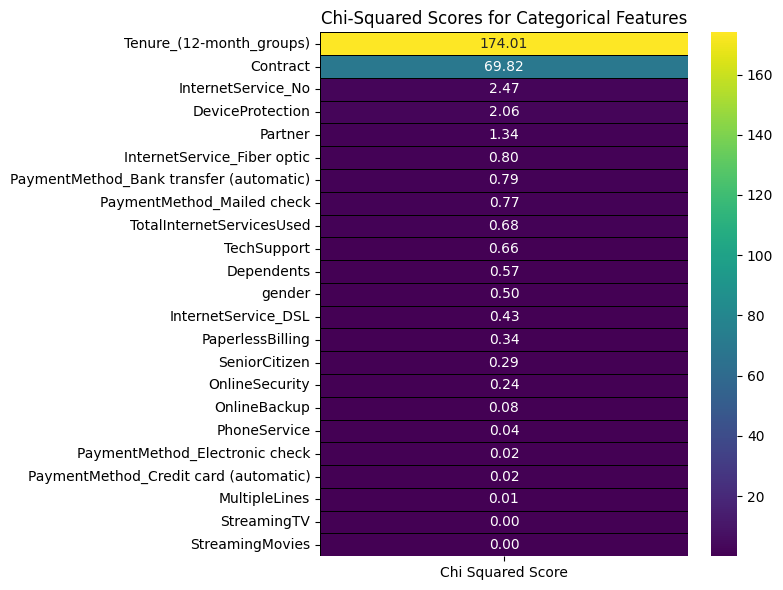

In [12]:
categorical_features = ['InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Contract', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Tenure_(12-month_groups)', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'SeniorCitizen',
       'TotalInternetServicesUsed']


features = X_train.loc[:, categorical_features]
target = pd.DataFrame(y_train, columns=['Churn'])

# Apply Chi-Squared test
best_features = SelectKBest(score_func=chi2, k='all')
fit = best_features.fit(features, target)

# DataFrame with Chi-Squared scores
featureScores = pd.DataFrame(data=fit.scores_, index=features.columns, columns=['Chi Squared Score'])

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(
    featureScores.sort_values(by='Chi Squared Score', ascending=False),
    annot=True, cmap='viridis', linewidths=0.4, linecolor='black', fmt='.2f'
)
plt.title('Chi-Squared Scores for Categorical Features')
plt.tight_layout()
plt.show()

In [54]:
X_train.columns

Index(['InternetService_DSL', 'InternetService_Fiber optic',
       'InternetService_No', 'PaymentMethod_Bank transfer (automatic)',
       'PaymentMethod_Credit card (automatic)',
       'PaymentMethod_Electronic check', 'PaymentMethod_Mailed check',
       'Contract', 'gender', 'Partner', 'Dependents', 'PhoneService',
       'PaperlessBilling', 'Tenure_(12-month_groups)', 'MultipleLines',
       'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport',
       'StreamingTV', 'StreamingMovies', 'SeniorCitizen', 'MonthlyCharges',
       'TotalInternetServicesUsed'],
      dtype='object')

#### ANOVA-based feature selection on the numerical features.

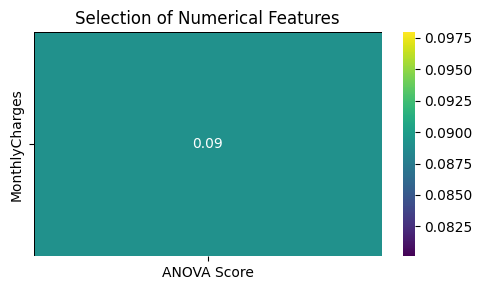

In [13]:
numerical_features = ['MonthlyCharges']

# Select numerical features from X_train_res
features = X_train.loc[:, numerical_features]
target = pd.DataFrame(y_train, columns=['Churn'])

# Apply ANOVA F-test
best_features = SelectKBest(score_func=f_classif, k='all')
fit = best_features.fit(features, target)

# Create a DataFrame with ANOVA scores
featureScores = pd.DataFrame(data=fit.scores_, index=features.columns, columns=['ANOVA Score'])

# Plot heatmap
plt.figure(figsize=(5, 3))
sns.heatmap(
    featureScores.sort_values(by='ANOVA Score', ascending=False),
    annot=True, cmap='viridis', linewidths=0.4, linecolor='black', fmt='.2f'
)
plt.title('Selection of Numerical Features')
plt.tight_layout()
plt.show()

#### Final Selected Features

In [148]:
# selected features based on Chi-Squared heatmap
selected_features_0 = ["Tenure_(12-month_groups)", "Contract", "InternetService_No", "DeviceProtection", "Partner", "InternetService_Fiber optic", "PaymentMethod_Bank transfer (automatic)", "PaymentMethod_Mailed check", "TotalInternetServicesUsed", "TechSupport", "MonthlyCharges"]
selected_features_1 = ["Tenure_(12-month_groups)", "Contract", "InternetService_No", "Partner", "InternetService_Fiber optic", "PaymentMethod_Bank transfer (automatic)", "PaymentMethod_Mailed check", "TotalInternetServicesUsed", "MonthlyCharges"]
selected_features_2 = ['InternetService_DSL', 'InternetService_Fiber optic','InternetService_No', 'TotalInternetServicesUsed', 'PhoneService', 'Partner', 'Dependents', 'Tenure_(12-month_groups)', 'Contract', 'PaymentMethod_Mailed check', 'PaymentMethod_Bank transfer (automatic)', "MonthlyCharges"]
selected_features_3 = ['InternetService_DSL', 'InternetService_Fiber optic','InternetService_No', 'TotalInternetServicesUsed', 'PhoneService', 'Partner', 'Dependents', 'Tenure_(12-month_groups)', 'Contract', "MonthlyCharges"]

# Filter the resampled training and test data
X_train_selected = X_train.loc[:, selected_features_1]
X_test_selected = X_test.loc[:, selected_features_1]

print("Final selected features:", selected_features_1)

Final selected features: ['Tenure_(12-month_groups)', 'Contract', 'InternetService_No', 'Partner', 'InternetService_Fiber optic', 'PaymentMethod_Bank transfer (automatic)', 'PaymentMethod_Mailed check', 'TotalInternetServicesUsed', 'MonthlyCharges']


## Scaling using StandardScaler

In [149]:
X_train_selected.head(2)

,Tenure_(12-month_groups),Contract,InternetService_No,Partner,InternetService_Fiber optic,PaymentMethod_Bank transfer (automatic),PaymentMethod_Mailed check,TotalInternetServicesUsed,MonthlyCharges
2262,0,1.0,0.0,1,0.0,0.0,0.0,0,120.00
355,3,1.0,0.0,1,1.0,0.0,0.0,3,85.24


In [150]:
# Make copies so original data is untouched
X_train_not_scaled = X_train_selected.copy()
X_test_not_scaled = X_test_selected.copy()

In [151]:
# Features to scale
col_to_scale = ['MonthlyCharges']

scaler_cls = StandardScaler()

# Fit-transform on train, transform on test
X_train_selected[col_to_scale] = scaler_cls.fit_transform(X_train_selected[col_to_scale])
X_test_selected[col_to_scale] = scaler_cls.transform(X_test_selected[col_to_scale])

## Model Training

Evaluation metrices

In [152]:
def evaluate(model, name, X_test, y_test):
    """Plot CM + ROC, print report, and append metrics dict to results_list."""
    # ---- predictions/scores ----
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = y_pred  # fallback; ROC will be less informative

    # ---- confusion matrix plot ----
    cm = confusion_matrix(y_test, y_pred)
    names = ['True Neg', 'False Pos', 'False Neg', 'True Pos']
    counts = cm.flatten()
    perc = [f"{v/cm.sum():.2%}" for v in counts]
    labels = np.array([f"{n}\n{c}\n{p}" for n, c, p in zip(names, counts, perc)]).reshape(2, 2)

    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=labels, fmt='', cmap='Blues', cbar=False)
    plt.xlabel('Predicted'); plt.ylabel('Actual'); plt.title(f'Confusion Matrix — {name}')
    plt.tight_layout(); plt.show()

    # ---- ROC plot ----
    fpr, tpr, _ = roc_curve(y_test, y_score)
    auc_val = roc_auc_score(y_test, y_score)
    plt.figure(figsize=(4, 3))
    plt.plot(fpr, tpr, label=f'AUC = {auc_val:.3f}')
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate'); plt.ylabel('True Positive Rate'); plt.title(f'ROC — {name}')
    plt.legend(loc='lower right'); plt.tight_layout(); plt.show()

    # ---- print report ----
    print(f"\n--- {name} ---")
    print(classification_report(y_test, y_pred, digits=3))
    print(f"ROC AUC: {auc_val:.3f}")

In [153]:
def store_results_table(model, name, X_test, y_test, results_rows):
    """Store metrics for all present classes + Accuracy + ROC AUC."""
    y_pred = model.predict(X_test)
    if hasattr(model, "predict_proba"):
        y_score = model.predict_proba(X_test)[:, 1]
    elif hasattr(model, "decision_function"):
        y_score = model.decision_function(X_test)
    else:
        y_score = y_pred

    auc_val = roc_auc_score(y_test, y_score)
    cr = classification_report(y_test, y_pred, output_dict=True, zero_division=0)

    # Detect actual label names from classification_report
    labels = [lbl for lbl in cr.keys() if lbl not in ("accuracy", "macro avg", "weighted avg")]

    row = {"Model": name, "Accuracy": cr["accuracy"], "ROC AUC": auc_val}
    for lbl in labels:
        row[f"Precision ({lbl})"] = cr[lbl]["precision"]
        row[f"Recall ({lbl})"]    = cr[lbl]["recall"]
        row[f"F1 ({lbl})"]        = cr[lbl]["f1-score"]

    results_rows.append(row)

def show_results_table(results_rows):
    df = pd.DataFrame(results_rows)
    display(df)
    return df

results_list = []

### 1. Logistic Regression

In [154]:
class_weights = {0.0: 1, 1.0: 3}

In [155]:
# train logistic regression model
ls = LogisticRegression(max_iter=100, solver='liblinear', random_state=42, class_weight='balanced')
ls.fit(X_train_selected, y_train)

LogisticRegression(class_weight='balanced', random_state=42, solver='liblinear')

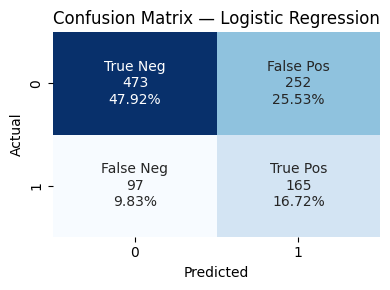

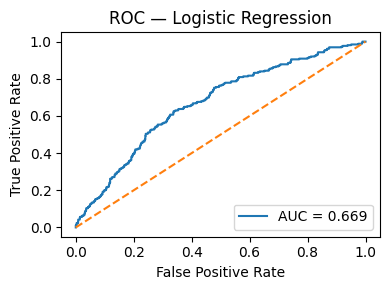


--- Logistic Regression ---
              precision    recall  f1-score   support

           0      0.830     0.652     0.731       725
           1      0.396     0.630     0.486       262

    accuracy                          0.646       987
   macro avg      0.613     0.641     0.608       987
weighted avg      0.715     0.646     0.666       987

ROC AUC: 0.669


In [156]:
# evaluate 
evaluate(ls, "Logistic Regression", X_test_selected, y_test)

In [157]:
pickle.dump(ls, open("processed_data/models/classification/logistic_reg_model_selected_features_1.pkl", "wb"))

In [158]:
store_results_table(ls, "Logistic Regression_selected_features_1", X_test_selected, y_test, results_list)

### 2. Random Forest

In [159]:
rfc = RandomForestClassifier(random_state=42, class_weight=class_weights)

Random Forest with Hyperparameter tuning

In [160]:
param_grid_rf = {
    'n_estimators': [100, 200, 500],
    'max_depth': [5, 8, 10],
    'min_samples_split': [2, 4, 6],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt', 'log2'],
}

grid_search_rf = GridSearchCV(estimator=rfc, param_grid=param_grid_rf, 
                    cv=5, n_jobs=-1, verbose=2)

grid_search_rf.fit(X_train_not_scaled, y_train)

print(f"\nBest Parameters found: {grid_search_rf.best_params_}")
best_rfc_model = grid_search_rf.best_estimator_

Fitting 5 folds for each of 108 candidates, totalling 540 fits

Best Parameters found: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 500}


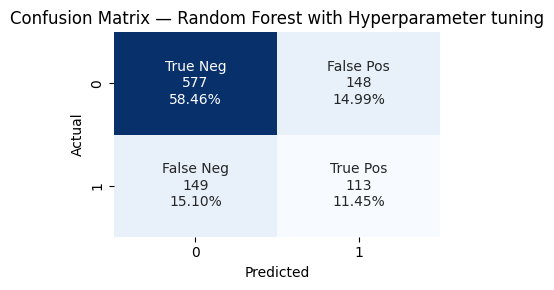

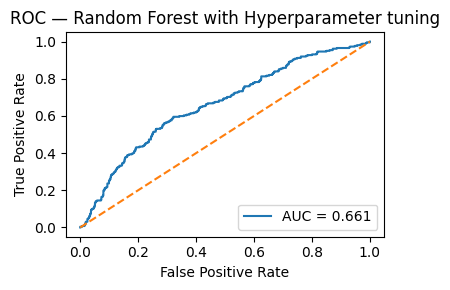


--- Random Forest with Hyperparameter tuning ---
              precision    recall  f1-score   support

           0      0.795     0.796     0.795       725
           1      0.433     0.431     0.432       262

    accuracy                          0.699       987
   macro avg      0.614     0.614     0.614       987
weighted avg      0.699     0.699     0.699       987

ROC AUC: 0.661


In [161]:
rfc_tuned_results = evaluate(best_rfc_model, "Random Forest with Hyperparameter tuning", X_test_not_scaled, y_test)

In [162]:
pickle.dump(best_rfc_model, open("processed_data/models/classification/random_forest_tuned_model_selected_features_1.pkl", "wb"))

In [163]:
store_results_table(best_rfc_model, "Random Forest Tuned_selected_features_1", X_test_not_scaled, y_test, results_list)

### 3. Support Vector Classifier (SVC)

SVM with Hyperparameter tuning

In [164]:
svm_tuned = SVC(random_state=42, probability=True, class_weight=class_weights)

param_grid_svm = {
    'C': [0.01, 0.1, 1, 10], 
    'kernel': ['linear', 'poly', 'rbf'],
    'gamma': ['scale', 'auto'],
    'degree': [2, 3, 4]
}

grid_search_svm = GridSearchCV(estimator=svm_tuned, param_grid=param_grid_svm, 
                    cv=3, n_jobs=-1, verbose=2)

grid_search_svm.fit(X_train_selected, y_train)

print(f"\nBest Parameters found: {grid_search_svm.best_params_}")
best_svc_model = grid_search_svm.best_estimator_

Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best Parameters found: {'C': 10, 'degree': 2, 'gamma': 'scale', 'kernel': 'rbf'}


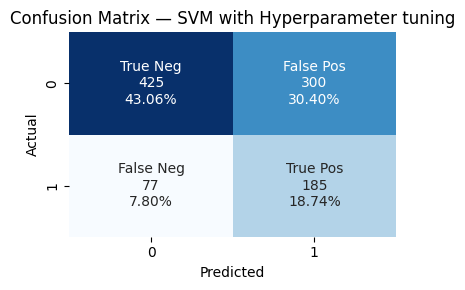

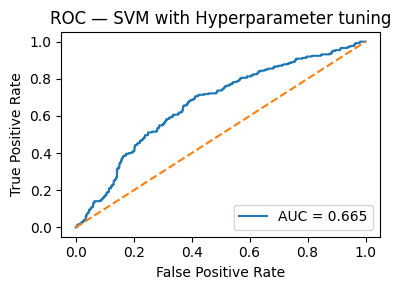


--- SVM with Hyperparameter tuning ---
              precision    recall  f1-score   support

           0      0.847     0.586     0.693       725
           1      0.381     0.706     0.495       262

    accuracy                          0.618       987
   macro avg      0.614     0.646     0.594       987
weighted avg      0.723     0.618     0.640       987

ROC AUC: 0.665


In [165]:
svm_tuned_results = evaluate(best_svc_model, "SVM with Hyperparameter tuning", X_test_selected, y_test)

In [166]:
pickle.dump(best_svc_model, open("processed_data/models/classification/svm_tuned_model_selected_features_1.pkl", "wb"))

In [167]:
store_results_table(best_svc_model, "SVM Tuned_selected_features_1", X_test_selected, y_test, results_list)

In [168]:
results_df = show_results_table(results_list)

,Model,Accuracy,ROC AUC,Precision (0),Recall (0),F1 (0),Precision (1),Recall (1),F1 (1)
0,Logistic Regression_selected_features_1,0.646403,0.668731,0.829825,0.652414,0.730502,0.395683,0.629771,0.486009
1,Random Forest Tuned_selected_features_1,0.699088,0.660574,0.794766,0.795862,0.795314,0.432950,0.431298,0.432122
2,SVM Tuned_selected_features_1,0.618034,0.665372,0.846614,0.586207,0.692747,0.381443,0.706107,0.495315


`selected_features_0 = ["Tenure_(12-month_groups)", "Contract", "InternetService_No", "DeviceProtection", "Partner", "InternetService_Fiber optic", "PaymentMethod_Bank transfer (automatic)", "PaymentMethod_Mailed check", "TotalInternetServicesUsed", "TechSupport", "MonthlyCharges"]`

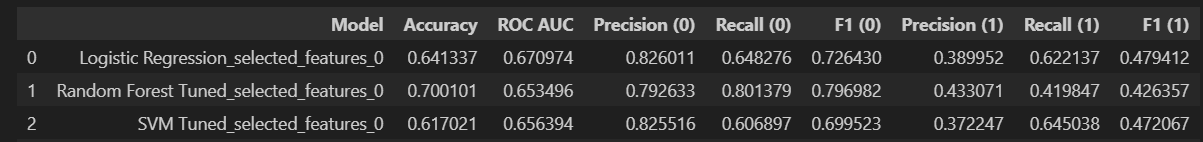

`selected_features_1 = ["Tenure_(12-month_groups)", "Contract", "InternetService_No", "Partner", "InternetService_Fiber optic", "PaymentMethod_Bank transfer (automatic)", "PaymentMethod_Mailed check", "TotalInternetServicesUsed", "MonthlyCharges"]`

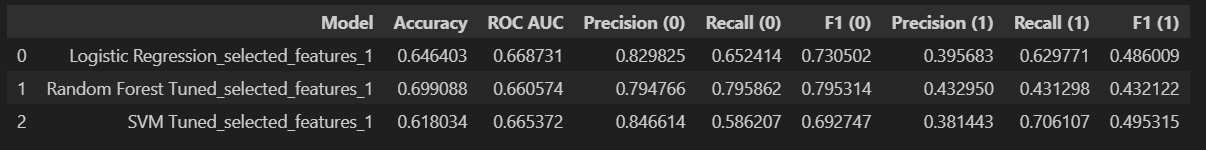'

`selected_features_2 = ['InternetService_DSL', 'InternetService_Fiber optic','InternetService_No', 'TotalInternetServicesUsed', 'PhoneService', 'Partner', 'Dependents', 'Tenure_(12-month_groups)', 'Contract', 'PaymentMethod_Mailed check', 'PaymentMethod_Bank transfer (automatic)', "MonthlyCharges"]`

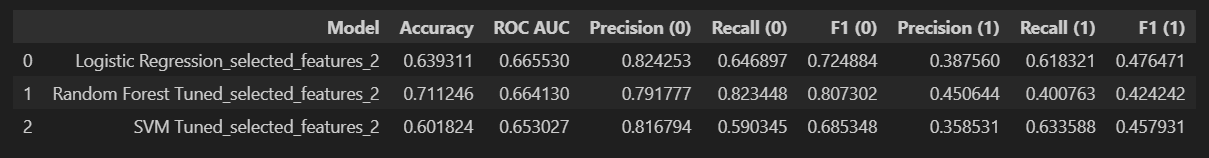

`selected_features_3 = ['InternetService_DSL', 'InternetService_Fiber optic','InternetService_No', 'TotalInternetServicesUsed', 'PhoneService', 'Partner', 'Dependents', 'Tenure_(12-month_groups)', 'Contract', "MonthlyCharges"]`

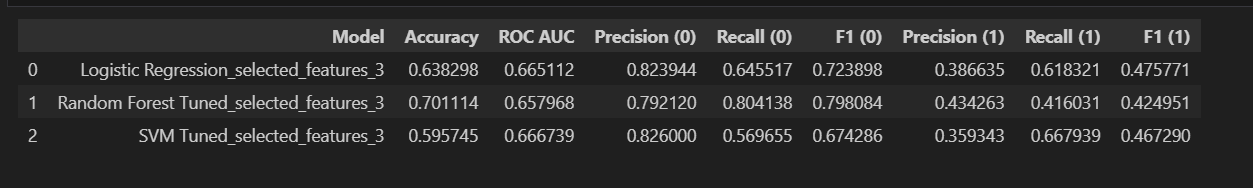